<a href="https://colab.research.google.com/github/vijpandaturtle/ActiveLearning/blob/master/Copy_of_Seizure_Recognition_LSTM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

USE IT FOR LOCAL RUNTIME

In [ ]:
# import os
# _src = os.path.join(os.getcwd(),"ThalamusData.mat")

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Load packages

In [ ]:
!pip install mne

     |████████████████████████████████| 6.8MB 4.8MB/s 


In [ ]:
# !pip freeze > requirements.txt

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *
from matplotlib import gridspec
import mne
from mne import find_events
from scipy.signal import resample, freqz_zpk, zpk2sos, sosfiltfilt, cheb2ord, iirdesign
import h5py
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.compat.v1.keras.models import Model
from tensorflow.compat.v1.keras.layers import Input, Dropout, BatchNormalization
from tensorflow.compat.v1.keras.layers import Conv1D, MaxPooling1D
from tensorflow.compat.v1.keras.layers import CuDNNLSTM, Bidirectional, Dense
# from tensorflow.keras.initializers import glorot_uniform
from tensorflow.compat.v1.keras.optimizers import Adam
from tensorflow.compat.v1.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow.compat.v1.keras.backend as K

%matplotlib inline
import scipy.io as sio
import re
import chardet
import os
import scipy.signal 

# Data Preparation

In [ ]:
class MatIngest:
    def __init__(self, filename, data_name):
        self.file = sio.loadmat(filename,
                                struct_as_record=False, squeeze_me=True)
        self.struct = self.file[data_name]

    def create_data_obj(self):
        """
        :return: a Dict contains Matlab Structure
        """
        struct = self.struct
        d = {}
        for attr in struct._fieldnames:
            d[attr] = getattr(struct, attr)
        return d

In [ ]:
def resample_by_interpolation(signal, input_fs, output_fs):

    scale = output_fs / input_fs
    # calculate new length of sample
    n = round(len(signal) * scale)

    # use linear interpolation
    # endpoint keyword means than linspace doesn't go all the way to 1.0
    # If it did, there are some off-by-one errors
    # e.g. scale=2.0, [1,2,3] should go to [1,1.5,2,2.5,3,3]
    # but with endpoint=True, we get [1,1.4,1.8,2.2,2.6,3]
    # Both are OK, but since resampling will often involve
    # exact ratios (i.e. for 44100 to 22050 or vice versa)
    # using endpoint=False gets less noise in the resampled sound
    resampled_signal = np.interp(
        np.linspace(0.0, 1.0, n, endpoint=False),  # where to interpret
        np.linspace(0.0, 1.0, len(signal), endpoint=False),  # known positions
        signal,  # known data points
    )
    return resampled_signal

In [ ]:
_src = "/content/gdrive/My Drive/BME-Bhargav-EEG-DeepLearning/data/ThalamusData.mat"
mat_data = MatIngest(filename=_src, data_name='ThalamusData').create_data_obj()

In [ ]:
data_sep = mat_data.get('SeparatedData')
del mat_data

In [ ]:
dataset = pd.DataFrame({'b_ictal': data_sep[:, 0], 'ictal': data_sep[:, 1], 'a_ictal': data_sep[:, 2]})

In [ ]:
dataset_b_ictal = pd.DataFrame({'b_ictal': data_sep[:, 0]})
data_b_ictal = pd.concat([dataset_b_ictal.b_ictal.apply(pd.Series)], axis=1)

In [ ]:
# data_b_ictal = data_ictal.iloc[10:].copy()

In [ ]:
dataset_ictal = pd.DataFrame({'ictal': data_sep[:, 1]})
data_ictal = pd.concat([dataset_ictal.ictal.apply(pd.Series)], axis=1)

### Plotting duration of before, after and ictal episodes

In [ ]:
dataset_ictal.shape

(92, 1)

Number of samples having duration above 150 seconds : 13


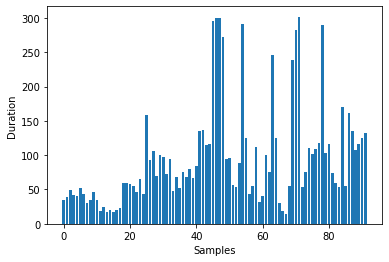

In [ ]:
duration = []
count = 0
frequency = 2048 #Hz
for i in range(dataset_ictal.shape[0]):
  duration.append(len(dataset_ictal.ictal[i])/2048)
  if (duration[i] > 150):
    count += 1

plt.bar([i for i in range(92)], duration)
plt.xlabel("Samples")
plt.ylabel("Duration in seconds")

print("Number of samples having duration above 150 seconds :", count)

In [ ]:
duration = []
count = 0
frequency = 2048 #Hz
for i in range(dataset_b_ictal.shape[0]):
  duration.append(len(dataset_b_ictal.b_ictal[i])/2048)
  # if (duration[i] > 150):
  #   count += 1

plt.bar([i for i in range(92)], duration)
plt.xlabel("Samples")
plt.ylabel("Duration in seconds")

#print("Number of samples having duration above 150 seconds :", count)

In [ ]:
duration = []
count = 0
frequency = 2048 #Hz
for i in range(dataset_a_ictal.shape[0]):
  duration.append(len(dataset_a_ictal.a_ictal[i])/2048)
  # if (duration[i] > 150):
  #   count += 1

plt.bar([i for i in range(92)], duration)
plt.xlabel("Samples")
plt.ylabel("Duration in seconds")

#print("Number of samples having duration above 150 seconds :", count)

In [ ]:
data_b_ictal = data_b_ictal.loc[:,0:data_ictal.shape[1]]

In [ ]:
dataset_a_ictal = pd.DataFrame({'a_ictal': data_sep[:, 2]})
data_a_ictal = pd.concat([dataset_a_ictal.a_ictal.apply(pd.Series)], axis=1)

In [ ]:
data_a_ictal = data_b_ictal.loc[:,0:data_ictal.shape[1]]

In [ ]:
data_b_ictal['y'] = 1

In [ ]:
data_b_ictal_drop = data_b_ictal.iloc[10:].copy()
del data_b_ictal

In [ ]:
# data_ictal = pd.concat([dataset.ictal.apply(pd.Series)], axis=1)
# data_ictal = data_ictal.fillna(data_ictal.mean())
data_ictal['y'] = 2

In [ ]:
data_ictal_drop = data_ictal.iloc[10:].copy()
del data_ictal

In [ ]:
data_ictal_drop.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,617754,617755,617756,617757,617758,617759,617760,617761,617762,617763,617764,617765,617766,617767,617768,617769,617770,617771,617772,617773,617774,617775,617776,617777,617778,617779,617780,617781,617782,617783,617784,617785,617786,617787,617788,617789,617790,617791,617792,y
10,-9.256652,-6.092211,-6.381828,-5.073729,-3.230614,-6.168795,-2.190807,-3.525137,-5.918223,-6.445928,-6.171869,-3.235479,-9.600165,-7.455138,-7.966500,-10.603326,-4.732691,-8.166792,-9.741042,-7.861167,-8.376366,-8.894637,-8.884790,-7.283802,-9.940437,-4.891849,-5.695906,-12.884149,-8.113223,-8.662456,-9.746121,-10.300256,-10.324190,-5.031978,-8.512462,-10.131223,-8.026700,-10.971050,-8.329997,-7.280777,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
11,1.026265,-2.186283,-6.194787,-0.630765,-1.178282,-1.988273,-1.997019,-4.394423,-2.268496,-3.328702,-4.650949,-3.842974,-3.829449,-2.484117,-3.529348,-0.585547,-1.362805,-5.330173,-0.791321,-1.039012,-2.617892,0.320021,0.596552,-3.383723,-3.645847,-2.848408,-2.320593,-3.125626,-1.009756,1.103173,-4.761647,-2.653179,-0.546086,-1.629778,-4.308553,-1.404024,1.235967,-3.034017,1.205404,1.460100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
12,-0.593641,-1.917383,-1.914152,-0.318224,-0.319716,-1.652733,0.202177,0.725927,-4.068859,-1.421451,1.756670,1.744219,-0.660824,-2.267967,1.176680,-2.555233,-3.361373,0.885293,-1.512022,-1.780353,1.143755,1.677665,-0.976225,-0.703750,0.899783,2.770737,1.718667,1.464943,2.009100,-0.371144,-1.156976,-0.880560,-1.403202,1.794103,1.799227,-0.856341,1.802538,1.534735,-1.393856,1.523844,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
13,1.141022,-2.330832,-1.554551,0.280452,-1.875957,-1.110900,2.576727,0.946993,-3.074724,-2.575485,-2.073580,1.622117,2.663990,-2.137388,2.371468,1.303689,-2.948079,-0.016162,-0.002899,2.408093,-0.227457,-0.466832,0.891455,0.390413,0.155680,-5.130772,-2.975505,-4.013257,-1.864686,3.735366,-0.771601,2.159586,1.097445,-4.489813,0.816762,-1.059768,-4.004517,-1.636630,0.462057,1.495024,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
14,0.721105,2.879381,1.320843,0.563559,-0.988948,1.712861,1.755617,-0.862162,2.365060,-0.261080,-1.563993,0.316263,0.859704,1.129311,1.656640,2.973543,0.295270,-1.060696,-0.295945,0.995619,3.612896,2.506370,0.867657,0.293304,-0.278582,2.875242,2.844219,3.351302,2.270648,1.197932,1.728556,-0.656743,-0.641359,2.837605,0.209101,-1.350144,2.146288,-2.595097,-0.422787,-0.642831,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


In [ ]:
# data_a_ictal = pd.concat([dataset.a_ictal.apply(pd.Series)], axis=1)
# data_a_ictal = data_a_ictal.fillna(data_a_ictal.mean())
data_a_ictal['y'] = 3

In [ ]:
data_a_ictal_drop = data_a_ictal.iloc[10:].copy()
del data_a_ictal

In [ ]:
del dataset

In [ ]:
merged_df = pd.concat([data_b_ictal, data_ictal, data_a_ictal])


In [ ]:
merged_df = merged_df.fillna(0)

In [ ]:
merged_df.reset_index(inplace = True,drop = True)

Down Sampling


In [ ]:
merged_df.head()

In [ ]:
labels_y = merged_df['y']
merged_df = merged_df.drop(columns=['y'])
resampled_signal = [resample_by_interpolation(merged_df.iloc[i].to_numpy(), 2048, 256) for i in range(len(merged_df))]
resampled_signal = np.array(resampled_signal)
df = pd.DataFrame(data = resampled_signal) 

In [ ]:
del merged_df

In [ ]:
#read in dataset from csv
df.index.name = "Patient_ID"
df.columns.name ="timepoints"
print(f"There are {len(df)} samples, each with 256 timestamps over 1 second (2048Hz sampling rate)")
df.head() # a preview of the dataset

There are 276 samples, each with 256 timestamps over 1 second (2048Hz sampling rate)


timepoints,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,77184,77185,77186,77187,77188,77189,77190,77191,77192,77193,77194,77195,77196,77197,77198,77199,77200,77201,77202,77203,77204,77205,77206,77207,77208,77209,77210,77211,77212,77213,77214,77215,77216,77217,77218,77219,77220,77221,77222,77223
Patient_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-5.804836,-9.670146,-10.012926,-11.794887,-6.230398,-0.649600,-2.965436,-3.864574,-0.749431,7.259556,6.782091,-2.877376,6.885347,0.777320,2.759816,-1.959165,-6.144644,-5.215559,-3.918065,0.600367,3.590392,7.523138,-0.117088,-3.578115,-5.995090,5.042473,9.871916,6.249010,7.117499,7.472339,12.326382,21.986688,26.032920,29.608065,38.132088,36.163577,40.152439,40.564922,49.111185,44.928997,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.262009,12.589948,5.169015,4.418880,6.797929,5.828812,9.471973,4.600965,-2.224875,-4.576244,-6.507120,-2.032751,-0.724684,-2.639317,-3.474576,-2.690510,1.194747,0.991522,0.545020,-8.614452,-2.751738,0.896129,-4.458141,-2.325525,-2.460966,-6.066630,2.196190,-1.852265,-7.488644,-2.958699,-7.077854,-2.459398,-4.523074,0.148153,-0.376541,5.400037,4.844596,7.997651,4.214970,5.287440,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.366735,-7.535026,5.719729,1.138012,-0.459370,-2.439386,4.026684,3.510716,-4.747618,0.408159,-3.419006,-0.031807,-8.471622,2.724754,-3.443188,2.847205,-0.031507,6.713361,9.200010,4.762600,-1.785754,-3.013555,-1.638491,-6.523306,0.097736,-2.590875,-4.010361,-9.293970,-5.447284,-0.059017,-1.568662,-0.929394,-1.938633,0.330632,1.412377,2.104880,-4.244446,-1.971875,-9.393710,-6.025545,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-20.758197,-20.171680,-15.560258,-10.571459,-5.580808,-9.476406,3.343752,12.334120,13.345545,15.530703,14.853615,13.391473,10.535513,13.358873,14.737844,7.983432,11.539386,14.793212,9.969175,16.800514,14.787008,9.746665,7.947743,-0.537665,2.212773,4.032241,7.120379,4.889152,0.847108,-0.614136,-3.317255,-1.847183,1.539667,6.504654,9.025764,5.334984,-3.747612,-6.938455,-14.986952,-9.583079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,16.528982,20.537240,21.947925,27.622131,30.506062,27.327641,27.820543,27.654044,27.167384,33.933230,35.435899,32.348575,28.187102,39.906744,37.314198,36.391302,38.925810,39.837611,37.309248,38.526068,37.804777,35.094493,40.444487,42.252275,42.604306,42.433593,39.533646,46.777997,49.302180,43.058794,44.296535,40.290651,34.605578,34.777489,42.009186,40.864875,41.538931,37.813367,35.864136,38.920251,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df['y'] = labels_y

## Visualize sample EEG traces

In [ ]:
# df_downsample = downsample(df,2048,256)

In [ ]:
plot(df[df["y"] == 2].indexes)

In [ ]:
df[df["y"] == 2].shape

(92, 77225)

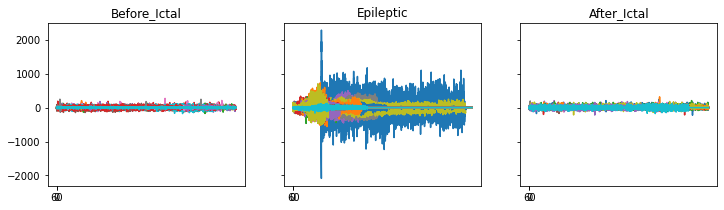

In [ ]:
# Show random samples from each group
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,3), sharey=True)

num_showing = 50  # number of traces showing from each group
labels = ["Before_Ictal", "Epileptic", "After_Ictal"]

for i, ax in enumerate(axes.flat):
    ax.set_title(labels[i])
    ax.set(xticks=np.arange(0,100,60))
    samples = df[df["y"] == (i+1)].sample(num_showing)
    for sample in range(len(samples)):
        ax.plot(np.arange(0,77224,1), samples.iloc[sample, :-1])


## Split train_test data

In [ ]:
del num_showing, axes

80:20 **Split** do for 50 times and then take average


In [ ]:
# split pandas dataframe to 80:20 for training and testing
train_X, test_X, train_y, test_y = train_test_split(
    df.iloc[:, :-1], 
    df.iloc[:, -1], 
    test_size=0.2,
    random_state=41,
)

# m_train, m_test: number of samples in train/test 
# Tx: number of timestamps
m_train, Tx = train_X.shape
m_test = test_X.shape[0]

# convert to numpy array. Keras does not take panads dataframe
train_X = train_X.to_numpy().reshape(m_train, Tx, 1)
test_X = test_X.to_numpy().reshape(m_test, Tx, 1)

print(f"num of samples {m_train}:{m_test}")
# convert label to one-hot
output_class = 3 # there are 3 possible predictions
# train_y range from 1-5. Make it from 0-4
train_y_OH = np.eye(output_class)[train_y-1]
test_y_OH = np.eye(output_class)[test_y-1]

print(f"train_X shape: {train_X.shape}")
print(f"train_y_OH shape: {train_y_OH.shape}")

print(f"test_X shape: {test_X.shape}")
print(f"test_y_OH shape: {test_y_OH.shape}")

num of samples 220:56
train_X shape: (220, 77224, 1)
train_y_OH shape: (220, 3)
test_X shape: (56, 77224, 1)
test_y_OH shape: (56, 3)


## Check sample balance
- This dataset is preprocessed and balanced, but it is a good practice to check
- Had the sample size not been balanced, we would need to get class weights in a dictionary and feed that into fit() during training

In [ ]:
# check training sample balance
balance_df = pd.DataFrame(
    {
    "train": train_y.value_counts(),
    "test": test_y.value_counts()
    }
 )

balance_df.index.name = "condition label"

print("No further balance is needed.")

balance_df

No further balance is needed.


,train,test
condition label,,
1,70,22
2,72,20
3,78,14


# Define model and train

## Model structure

#### 3 Conv1D blocks:
- Conv1D --> BatchNorm --> Dropout --> MaxPooling

#### 3 LSTM blocks:
- Bidirectional LSTM --> Dropout

#### Final Dense layer
- Dense --> BatchNorm --> Dropout --> Dense softmax output

In [ ]:
layer_count=0 # for tracking layer names
X_input = Input(shape=(Tx,1), name=f"input_{layer_count}")
X = X_input

In [ ]:

layer_count += 1
X = Conv1D(32, kernel_size=20, padding="valid", activation="relu", name=f"Conv_{layer_count}")(X)
X = Dropout(0.25, name=f"DP_{layer_count}")(X)
X = BatchNormalization(name=f"BN_{layer_count}")(X)
X = MaxPooling1D(pool_size=2, name=f"MP_{layer_count}")(X)

layer_count += 1
X = Conv1D(64, kernel_size=10, padding="valid", activation="relu", name=f"Conv_{layer_count}")(X)
X = Dropout(0.25, name=f"DP_{layer_count}")(X)
X = BatchNormalization(name=f"BN_{layer_count}")(X)
X = MaxPooling1D(pool_size=2, name=f"MP_{layer_count}")(X)

layer_count += 1
X = Conv1D(128, kernel_size=10, padding="valid", activation="relu", name=f"Conv_{layer_count}")(X)
X = Dropout(0.25, name=f"DP_{layer_count}")(X)
X = BatchNormalization(name=f"BN_{layer_count}")(X)
X = MaxPooling1D(pool_size=2, name=f"MP_{layer_count}")(X)

In [ ]:
layer_count += 1
X = Bidirectional(CuDNNLSTM(80, return_sequences=True, kernel_regularizer="l2"), name=f"BiLSTM_{layer_count}")(X)
X = Dropout(0.25, name=f"DP_{layer_count}")(X)
X = BatchNormalization(name=f"BN_{layer_count}")(X)


layer_count += 1
X = Bidirectional(CuDNNLSTM(80, return_sequences=True, kernel_regularizer="l2"), name=f"BiLSTM_{layer_count}")(X)
X = Dropout(0.25, name=f"DP_{layer_count}")(X)
X = BatchNormalization(name=f"BN_{layer_count}")(X)


layer_count += 1    
X = Bidirectional(CuDNNLSTM(80, kernel_regularizer="l2"), name=f"BiLSTM_{layer_count}")(X)
X = Dropout(0.25, name=f"DP_{layer_count}")(X)
X = BatchNormalization(name=f"BN_{layer_count}")(X)


In [ ]:
layer_count += 1
X = Dense(80, activation="relu", name=f"Dense_{layer_count}")(X)
X = Dropout(0.25, name=f"DP_{layer_count}")(X)
X = BatchNormalization(name=f"BN_{layer_count}")(X)

layer_count += 1
# X = Dropout(0.25, name=f"DP_{layer_count}_2")(X)
output = Dense(3, activation="softmax", name=f"output_{layer_count}")(X)

model = Model(inputs=X_input, outputs=output)

## Create model graph and train

In [ ]:
input_shape = train_X.shape[1]

# model_ntc = LSTM_model(Tx=input_shape, name="model_ntc", temporal_conv=False)
# model_ntc.summary()
# import pdb
# pdb.set_trace()
# model_tc.summary()

In [ ]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_0 (InputLayer)         [(None, 77224, 1)]        0         
_________________________________________________________________
Conv_1 (Conv1D)              (None, 77205, 32)         672       
_________________________________________________________________
DP_1 (Dropout)               (None, 77205, 32)         0         
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 77205, 32)         128       
_________________________________________________________________
MP_1 (MaxPooling1D)          (None, 38602, 32)         0         
_________________________________________________________________
Conv_2 (Conv1D)              (None, 38593, 64)         20544     
_________________________________________________________________
DP_2 (Dropout)               (None, 38593, 64)        

In [ ]:
histories = {}

opt=Adam(lr=1e-3)

lr_reduction = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2, 
    patience=10, 
    verbose=1,
    min_delta=1e-4,
    cooldown=0,
    min_lr=1e-6
)

early_stop = EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=25, 
    verbose=1,
)

model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])
print(f"Start training {model.name}")

histories[model.name] = model.fit(
    train_X, 
    train_y_OH,
    validation_split=0.1, 
    batch_size=16, 
    epochs=100,
    callbacks=[lr_reduction, early_stop],
    verbose=0
)

# for model in [model_ntc]: # [model_ntc, model_tc]

#     opt=Adam(lr=1e-3)

#     lr_reduction = ReduceLROnPlateau(
#         monitor="val_loss",
#         factor=0.2, 
#         patience=10, 
#         verbose=1,
#         min_delta=1e-4,
#         cooldown=0,
#         min_lr=1e-6
#     )

#     early_stop = EarlyStopping(
#         monitor='val_loss', 
#         min_delta=0, 
#         patience=25, 
#         verbose=1,
#     )

#     model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])
#     print(f"Start training {model.name}")

#     histories[model.name] = model.fit(
#         train_X, 
#         train_y_OH,
#         validation_split=0.1, 
#         batch_size=64, 
#         epochs=150,
#         callbacks=[lr_reduction, early_stop],
#         verbose=0
#     )

Start training functional_3


KeyboardInterrupt: ignored

[(0.4, 0.9)]

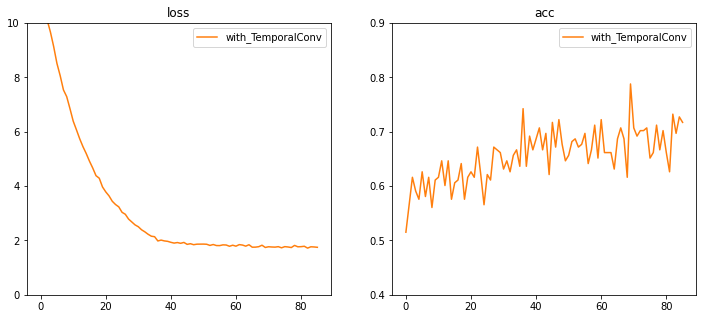

In [ ]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

for m, ax in zip(["loss", "acc"], axes.flat):

  # ax.plot(histories["model_ntc"].history[m], label="no_TemporalConv", color="C0")
  # ax.plot(histories["model_ntc"].history[f"val_{m}"], label="no_TemporalConv_val", color="C0", linestyle="--")
  ax.plot(histories["functional_1"].history[m], label="with_TemporalConv", color="C1")
  #ax.plot(histories["model"].history[f"val_{m}"], label="with_TemporalConv_val", color="C1", linestyle="--")
  ax.set(title=m)
  ax.legend()
axes[0].set(ylim=(0,10))
axes[1].set(ylim=(0.4,0.9))

# Performance

In [ ]:
# pred_OH = model.predict(test_X) # pred_OH shape (num_sample, num_class) values are prob
# print(pred_OH)
# pred = np.argmax(pred_OH, axis=-1) # get prediction class 0-4
# print(pred)

              precision    recall  f1-score   support

Before Ictal       0.50      0.55      0.52        22
      During       0.00      0.00      0.00        20
 After Ictal       0.09      0.21      0.13        14

    accuracy                           0.27        56
   macro avg       0.20      0.25      0.22        56
weighted avg       0.22      0.27      0.24        56



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


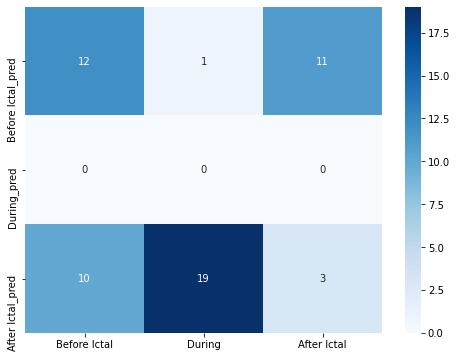

In [ ]:
# test_y range from 1-5, covnert to 0-4
groups = ["Before Ictal", "During", "After Ictal"]
confusion = confusion_matrix(test_y-1, pred)

report = classification_report(test_y-1, pred, target_names=groups)

print(report)

confusion = pd.DataFrame(confusion.T, index=[f"{g}_pred" for g in groups], columns=groups)
plt.figure(figsize=(8,6))
sns.heatmap(confusion, annot=True, annot_kws={"size":10}, cmap="Blues")

# Conclusion

- Adding temporal conv layers before LSTM helps neural network learns faster and better. 
- In general, model_tc is performing well in differentiating major groups: healthy, tumor, epileptic; however, it is having a bit hard time telling minor groups: Tumor_TumorArea vs Tumor_HealthyArea and Healthy_EyeClose vs Healthy_EyeOpen.
- Interestingly, 19 recordings from Tumor_healthyArea were classified as healthy_EyeOpen, suggesting the local neuronal activities are not affected by tumor mass. 
